<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>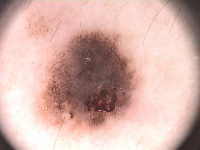</td><td>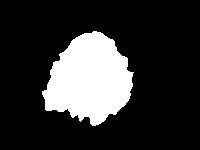</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
! wget https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

--2021-12-11 19:28:27--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/8lqrloi0mxj2acu/PH2Dataset.rar [following]
--2021-12-11 19:28:27--  https://www.dropbox.com/s/raw/8lqrloi0mxj2acu/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc01d6d377edd131cfa439ca619c.dl.dropboxusercontent.com/cd/0/inline/BboVQulx1anmLDa-1cJjWUspGEftjQKFaDJDx0sK266IP8uV4E7zWnBBLDx_XygupVd7C3qupzwE4DX_SwitnKs4TGREyCwkgY9FKpzhJDDrCRbhgVUxgWODt1pNcgnPtyZViZYqnKOowk6YmjK70VGf/file# [following]
--2021-12-11 19:28:27--  https://uc01d6d377edd131cfa439ca619c.dl.dropboxusercontent.com/cd/0/inline/BboVQulx1anmLDa-1cJjWUspGEftjQKFaDJDx0sK266IP8uV4E7zWnBBLDx_XygupVd7C3qupzwE4DX_Swit

In [2]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [3]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [4]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [5]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

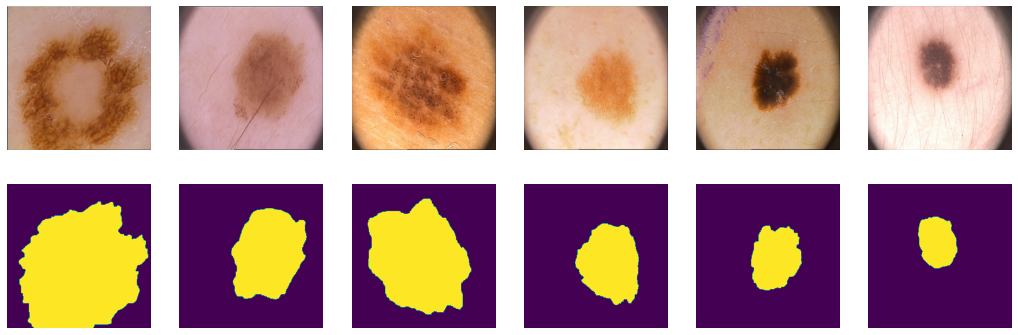

In [6]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [7]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [8]:
from torch.utils.data import DataLoader
batch_size = 5
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [9]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

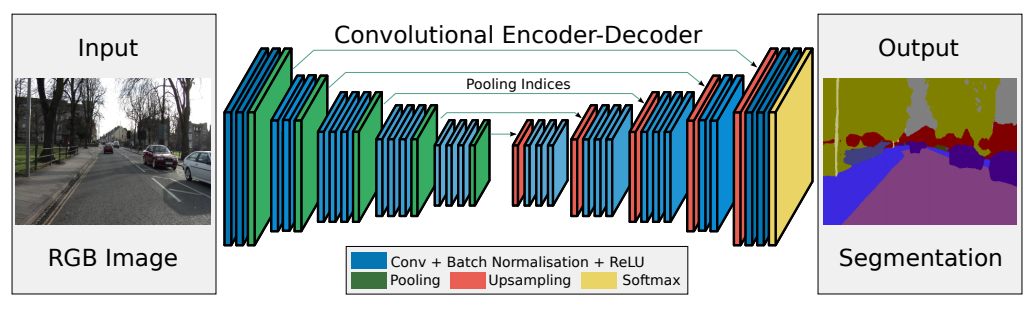

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [10]:
for X_batch, Y_batch in data_tr:
  print(X_batch.size())
  break

torch.Size([25, 3, 256, 256])


In [ ]:
from torchvision import models

In [ ]:
model_extractor = models.vgg16(pretrained=True)
print(model_extractor)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 =nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3),stride=(1,1),padding=(1,1) ),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            
        )
        self.pool0 =   nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False,return_indices=True)# 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False,return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False,return_indices=True) # 64 -> 32
        self.enc_conv3 =nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False,return_indices=True) # 32 -> 16

        # # bottleneck
        self.bottleneck1_conv = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
        )
        self.bottleneck1_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False,return_indices=True)
        self.bottleneck2unpool = nn.MaxUnpool2d(2)
        self.bottleneck2_conv = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
        )

        # # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU()
        ) 
        self.upsample1 = nn.MaxUnpool2d(2)  # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU()
        ) 
        self.upsample2 = nn.MaxUnpool2d(2)   # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
        ) 
        self.upsample3 = nn.MaxUnpool2d(2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
        ) 

    def forward(self, x):
        # encoder
        e0,i1 = self.pool0(self.enc_conv0(x))
        e1,i2 = self.pool1(self.enc_conv1(e0))
        e2,i3 = self.pool2(self.enc_conv2(e1))
        e3,i4 =self.pool3(self.enc_conv3(e2))

        # bottleneck
        b1,i5 = self.bottleneck1_pool(self.bottleneck1_conv(e3)) 
        b2 = self.bottleneck2_conv(self.bottleneck2unpool(b1,i5))
        # # decoder
        d0 = self.dec_conv0(self.upsample0(b2,i4)) 
        d1 = self.dec_conv1(self.upsample1(d0,i3)) 
        d2 = self.dec_conv2(self.upsample2(d1,i2)) 
        d3 = self.dec_conv3(self.upsample3(d2,i1)) # no activation
        return d3

In [ ]:
model = SegNet()
for X_batch, Y_batch in data_tr:
  y_pred1 = model(X_batch)
  break
print(y_pred1.size())

torch.Size([25, 1, 256, 256])


## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [11]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [12]:
def bce_loss(y_real, y_pred):
    # TODO 
    # please don't use nn.BCELoss. write it from scratch
    return  torch.mean(y_pred-y_real*y_pred+torch.log(1+torch.exp(-y_pred)))

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [33]:
def train(model, opt, loss_fn, epochs, data_tr, data_val,losses,tr_losses,val_score,tr_score):
    X_val, Y_val = next(iter(data_val))
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss =  loss_fn(Y_batch,Y_pred)# forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
            X_batch = X_batch.cpu()
            Y_batch = Y_batch.cpu()
            del X_batch
            del Y_batch
            torch.cuda.empty_cache()
        tr_score.append(score_model(model, iou_pytorch, data_tr))
        tr_losses.append(avg_loss)
        toc = time()
        print('loss: %f' % avg_loss)
        
        # show intermediate results
        model.eval()  # testing mode
        val_score.append(score_model(model, iou_pytorch, data_val))
        X_val = X_val.to(device)
        Y_hat = torch.sigmoid(model(X_val)).detach().cpu()>0.5# detach and put into cpu
        X_val = X_val.cpu()
        torch.cuda.empty_cache ()
        # Visualize tools
        clear_output(wait=True)
        losses.append(val_loss(model,data_val,loss_fn))
        for k in range(5):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
    del Y_hat
    del X_val
    del Y_val
    torch.cuda.empty_cache()

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [14]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [15]:
def val_loss(model,data,loss_fn):
  model.eval()
  avg_loss = 0
  for X_batch, Y_label in data:
      X_batch = X_batch.to(device)
      Y_label = Y_label.to(device)
      with torch.set_grad_enabled(False):
        Y_pred = model(X_batch)
        loss =  loss_fn(Y_label,Y_pred)
      avg_loss += loss / len(data)
      X_batch = X_batch.cpu()
      Y_pred = Y_pred.cpu()
      Y_label = Y_label.cpu()       
      del X_batch
      del Y_pred
      del Y_label
      torch.cuda.empty_cache()
  return avg_loss

In [16]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        Y_label = Y_label.to(device)
        Y_pred = torch.sigmoid(model(X_batch))>0.5
        scores += metric(Y_pred, Y_label.to(device)).mean().item()
        X_batch = X_batch.cpu()
        Y_pred = Y_pred.cpu()
        Y_label = Y_label.cpu()       
        del X_batch
        del Y_pred
        del Y_label
        torch.cuda.empty_cache()
    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [ ]:
model = SegNet().to(device)
print(device)

cuda


In [ ]:
# import GPUtil
# del Y
model.cpu()
del model
# del optimizer
# GPUtil.showUtilization()
# torch.cuda.empty_cache()
# GPUtil.showUtilization()

In [ ]:
!pip install torchinfo

In [ ]:
import torchinfo
from torchinfo import summary
summary(model, (5,3,256,256))

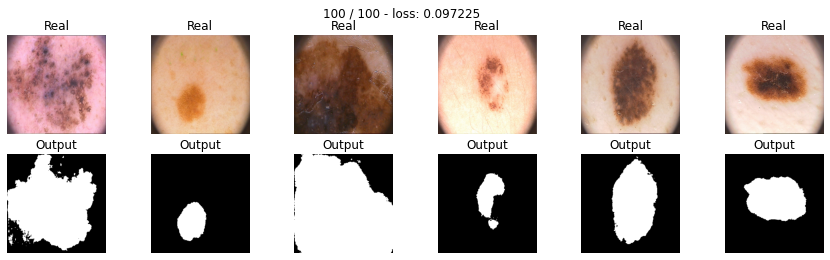

In [ ]:
max_epochs = 100
optimizer = optim.Adam(model.parameters())
losses = []
train(model, optimizer, bce_loss, max_epochs, data_tr, data_val,losses)

In [ ]:
score_model(model, iou_pytorch, data_val)

0.715999960899353

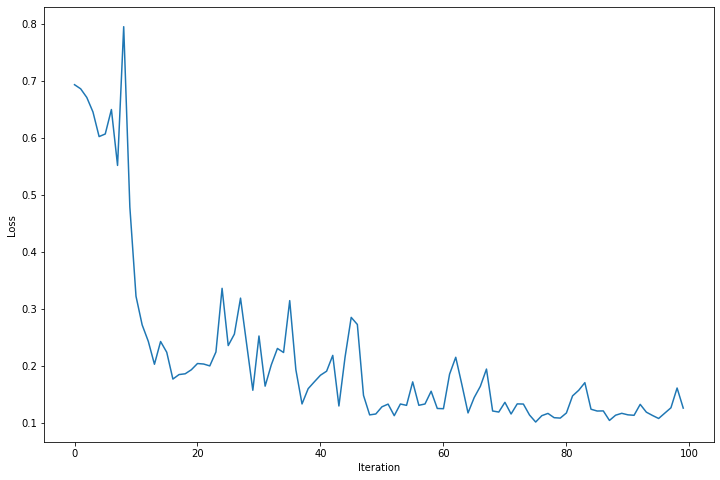

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

Ответьте себе на вопрос: не переобучается ли моя модель?

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
def dice_loss(targets, inputs):
    inputs = F.sigmoid(inputs)       
    smooth=1
    #flatten label and prediction tensors
    inputs = inputs.view(-1)
    targets = targets.view(-1)
    
    intersection = (inputs * targets).sum()                            
    dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
    
    return 1 - dice


Проводим тестирование:

In [ ]:
model_dice = SegNet().to(device)

max_epochs = 60
losses = []
tr_losses = []
optimaizer = optim.Adam(model_dice.parameters())
train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val,losses,tr_losses)

In [ ]:
score_model(model_dice, iou_pytorch, data_val)

0.6120000183582306

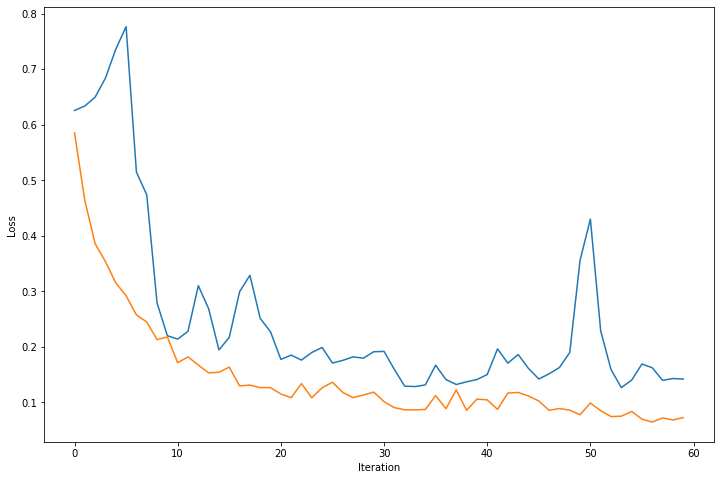

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.plot(range(len(tr_losses)), tr_losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [55]:
def focal_loss(targets, inputs, eps = 1e-8, gamma = 2):
    # p = torch.sigmoid(y_pred)
    # p =  torch.clamp(p,min=eps)# hint: torch.clamp
    # # bce_loss = (y_real*torch.log(p) + (1-y_real) * torch.log(1-p))
    
    # bce_exp = -bce_loss(y_real,y_pred)
    # loss = ( * ((1 - p) ** gamma))
    
    # return loss
    inputs = torch.sigmoid(inputs)       
    
    #flatten label and prediction tensors
    inputs = inputs.view(-1)
    targets = targets.view(-1)
    
    #first compute binary cross-entropy 
    BCE = bce_loss(targets,inputs)
    BCE_EXP = torch.exp(-BCE)
    focal_loss = (1-BCE_EXP)**gamma * BCE
    return focal_loss

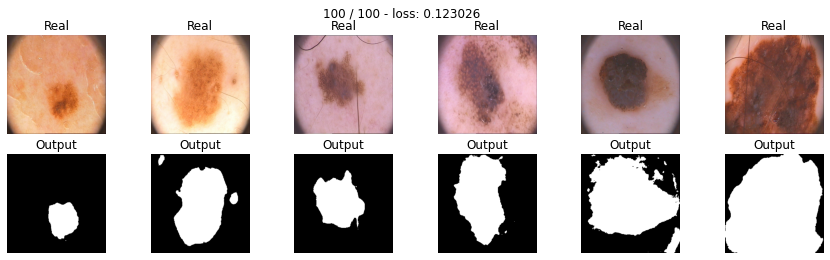

In [ ]:
model_focal = SegNet().to(device)

max_epochs = 100
losses = []
tr_losses = []
optimaizer = optim.Adam(model_focal.parameters())
train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val,losses,tr_losses)

In [ ]:
score_model(model_focal, iou_pytorch, data_val)

0.6899999976158142

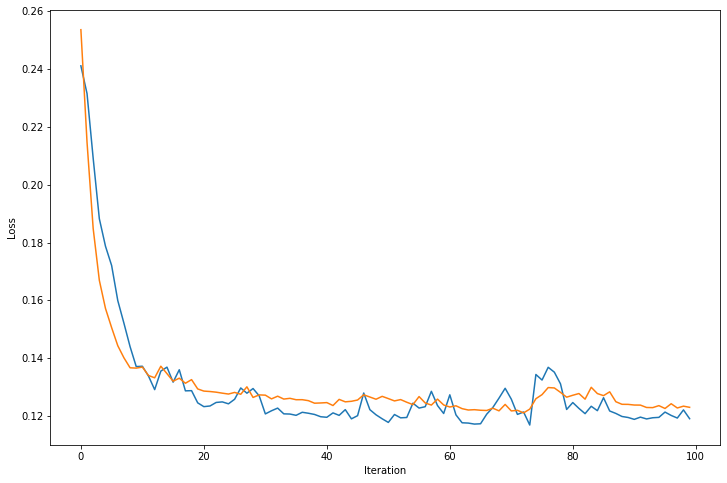

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses,label="validation")
plt.plot(range(len(tr_losses)), tr_losses,label = "train")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [21]:
from torch.autograd import Variable
def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.view(-1)
    labels = labels.view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels

def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1: # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss

def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), Variable(grad))
    return loss

#=====
#Multi-class Lovasz loss
#=====

def lovasz_softmax(probas, labels, classes='present', per_image=False, ignore=None):
    """
    Multi-class Lovasz-Softmax loss
      probas: [B, C, H, W] Variable, class probabilities at each prediction (between 0 and 1).
              Interpreted as binary (sigmoid) output with outputs of size [B, H, W].
      labels: [B, H, W] Tensor, ground truth labels (between 0 and C - 1)
      classes: 'all' for all, 'present' for classes present in labels, or a list of classes to average.
      per_image: compute the loss per image instead of per batch
      ignore: void class labels
    """
    if per_image:
        loss = mean(lovasz_softmax_flat(*flatten_probas(prob.unsqueeze(0), lab.unsqueeze(0), ignore), classes=classes)
                          for prob, lab in zip(probas, labels))
    else:
        loss = lovasz_softmax_flat(*flatten_probas(probas, labels, ignore), classes=classes)
    return loss


def lovasz_softmax_flat(probas, labels, classes='present'):
    """
    Multi-class Lovasz-Softmax loss
      probas: [P, C] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [P] Tensor, ground truth labels (between 0 and C - 1)
      classes: 'all' for all, 'present' for classes present in labels, or a list of classes to average.
    """
    if probas.numel() == 0:
        # only void pixels, the gradients should be 0
        return probas * 0.
    C = probas.size(1)
    losses = []
    class_to_sum = list(range(C)) if classes in ['all', 'present'] else classes
    for c in class_to_sum:
        fg = (labels == c).float() # foreground for class c
        if (classes is 'present' and fg.sum() == 0):
            continue
        if C == 1:
            if len(classes) > 1:
                raise ValueError('Sigmoid output possible only with 1 class')
            class_pred = probas[:, 0]
        else:
            class_pred = probas[:, c]
        errors = (Variable(fg) - class_pred).abs()
        errors_sorted, perm = torch.sort(errors, 0, descending=True)
        perm = perm.data
        fg_sorted = fg[perm]
        losses.append(torch.dot(errors_sorted, Variable(lovasz_grad(fg_sorted))))
    return mean(losses)

In [19]:
def LovaszHingeLoss(targets, inputs):
    inputs = F.sigmoid(inputs)    
    Lovasz = lovasz_hinge(inputs, targets, per_image=False)                       
    return Lovasz

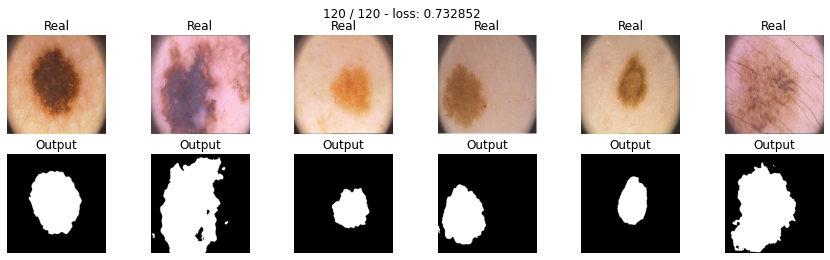

In [34]:
model_boundary = SegNet().to(device)

max_epochs = 120
losses = []
tr_losses = []
val_score = []
tr_score = []
optimaizer = optim.AdamW(model_boundary.parameters())
train(model_boundary, optimaizer, LovaszHingeLoss, max_epochs, data_tr, data_val,losses,tr_losses,val_score,tr_score)

In [35]:
score_model(model_boundary, iou_pytorch, data_val)

0.5620000064373016

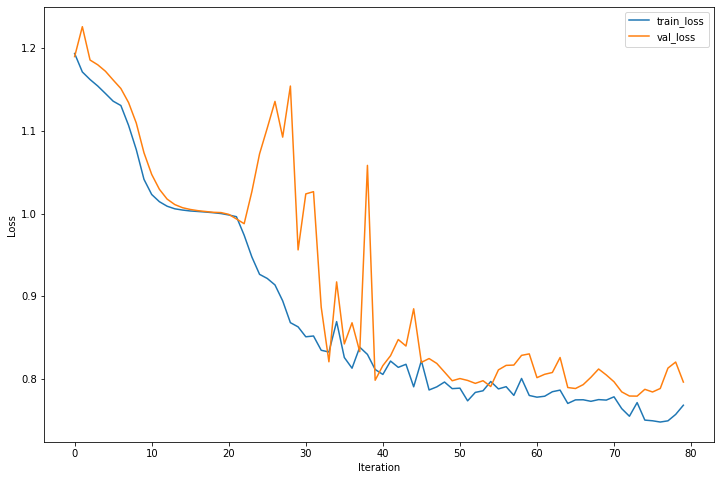

In [32]:
plt.figure(figsize=(12, 8))
plt.plot(tr_losses, label="train_loss")
plt.plot(losses, label="val_loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

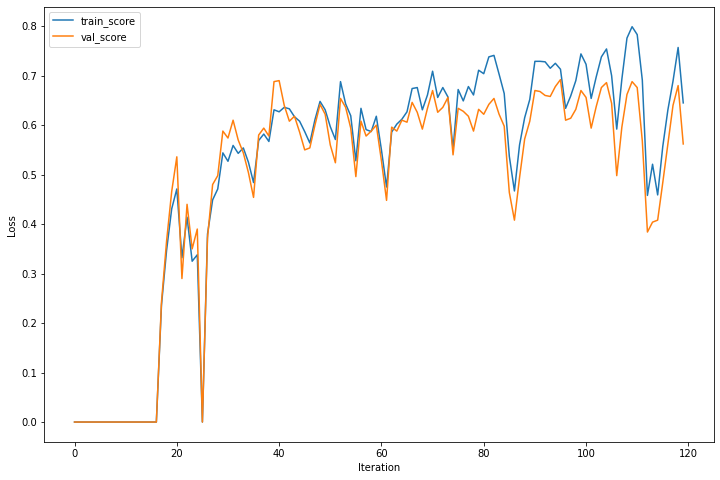

In [36]:
plt.figure(figsize=(12, 8))
plt.plot(tr_score, label="train_score")
plt.plot(val_score, label="val_score")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

Как видим произошло переобучение, но исходя из предыдущих попыток модно заметить что наибольший score на валидационной выборке равен 0.68 

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

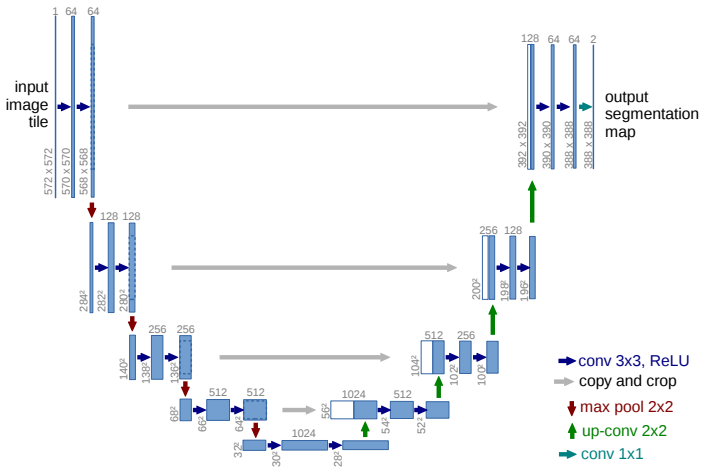

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [44]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 =nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3),stride=(1,1),padding=(1,1) ),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU()
        )
        self.pool0 =  nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False,return_indices=True)# 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3),stride=(1,1),padding=(1,1) ),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU()
        )
        self.pool1 =  nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False,return_indices=True)  # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3),stride=(1,1),padding=(1,1) ),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False,return_indices=True) # 64 -> 32
        self.enc_conv3 =nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3),stride=(1,1),padding=(1,1) ),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False,return_indices=True) # 32 -> 16

        # bottleneck
        self.enc_bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=(3,3),stride=(1,1),padding=(1,1) ),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU()
        )

        self.dec_bottleneck_unpool = nn.MaxUnpool2d(2) #16->32

        self.dec_bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
        )
        # # decoder (upsampling)
        self.upsample0 =nn.MaxUnpool2d(2)  # 32 -> 64
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
        )
        self.upsample1 = nn.MaxUnpool2d(2) # 64-> 128
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
        )
        self.upsample2 = nn.MaxUnpool2d(2)  # 128 -> 256
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=1),
            nn.ReLU()
        )

    def forward(self, x):
        # encoder
        e01 = self.enc_conv0(x)
        e0,i0 = self.pool0(e01)

        e11 = self.enc_conv1(e0)
        e1,i1 = self.pool1(e11)

        e21 = self.enc_conv2(e1)
        e2,i2 = self.pool2(e21)

        e31 = self.enc_conv3(e2)
        e3,i3 = self.pool3(e31)
       

        # # bottleneck
        b1= self.enc_bottleneck_conv(e3)
        
        b2 = self.dec_bottleneck_unpool(b1,i3)
      
        b2 = torch.cat((b2, e31), dim=1)
        
        b2 = self.dec_bottleneck_conv(b2)
        # decoder
        
        d0 = self.dec_conv0(torch.cat((e21,self.upsample0(b2,i2)), dim=1))
        d1 = self.dec_conv1(torch.cat((e11,self.upsample1(d0,i1)), dim=1))
        d2 = self.dec_conv2(torch.cat((e01,self.upsample2(d1,i0)), dim=1))# no activation
        return d2

In [45]:
unet_model = UNet()
for x,y in data_tr:
  y1 = unet_model(x)
  print(y1.size())
  break

torch.Size([5, 1, 256, 256])


In [57]:
unet_model = UNet().to(device)

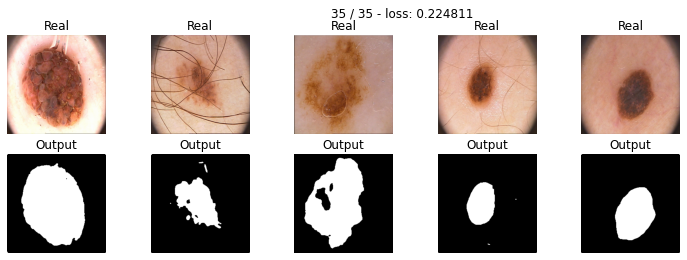

In [58]:
max_epochs =35
losses = []
tr_losses = []
val_score = []
tr_score = []
optimaizer = optim.AdamW(unet_model.parameters())
train(unet_model, optimaizer, focal_loss, max_epochs, data_tr, data_val,losses,tr_losses,val_score,tr_score)

In [59]:
score_model(unet_model, iou_pytorch, data_val)

0.6700000196695328

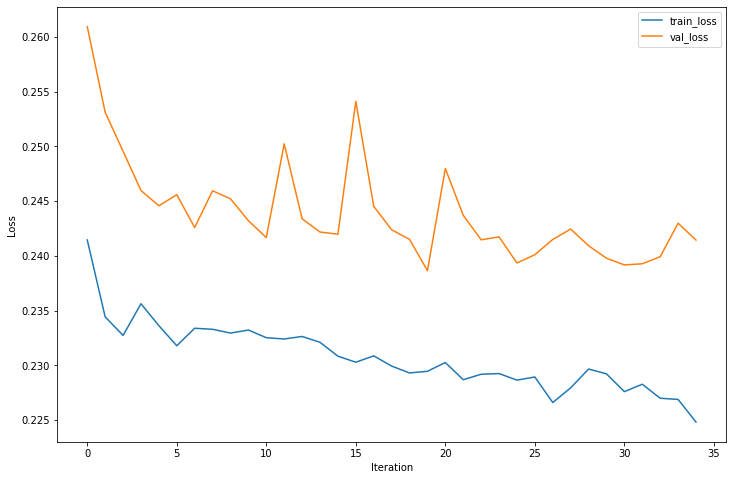

In [60]:
plt.figure(figsize=(12, 8))
plt.plot(tr_losses, label="train_loss")
plt.plot(losses, label="val_loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

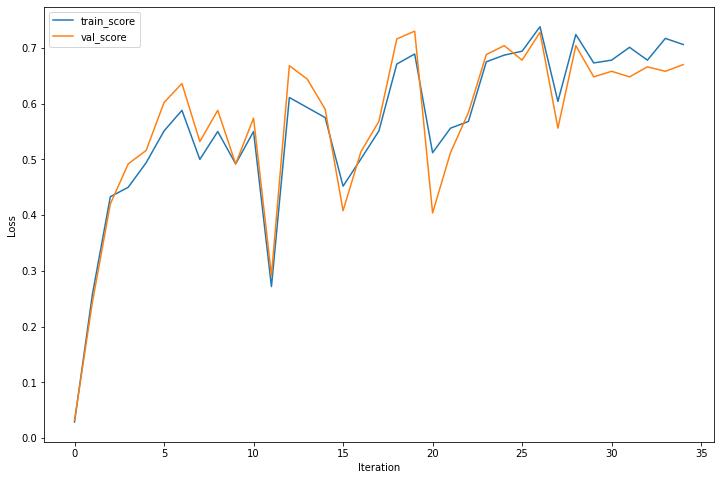

In [61]:
plt.figure(figsize=(12, 8))
plt.plot(tr_score, label="train_score")
plt.plot(val_score, label="val_score")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

Для BCE: 0.72

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [46]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 =nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3),stride=(1,1),padding=(1,1) ),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU()
        )
        self.pool0 =  nn.Conv2d(in_channels=64, out_channels=64,kernel_size=2,stride=2)# 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3),stride=(1,1),padding=(1,1) ),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU()
        )
        self.pool1 =  nn.Conv2d(in_channels=128, out_channels=128,kernel_size=2,stride=2)  # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3),stride=(1,1),padding=(1,1) ),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU()
        )
        self.pool2 = nn.Conv2d(in_channels=256, out_channels=256,kernel_size=2,stride=2) # 64 -> 32
        self.enc_conv3 =nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3),stride=(1,1),padding=(1,1) ),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU()
        )
        self.pool3 = nn.Conv2d(in_channels=512, out_channels=512,kernel_size=2,stride=2) # 32 -> 16

        # bottleneck
        self.enc_bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=(3,3),stride=(1,1),padding=(1,1) ),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU()
        )

        self.dec_bottleneck_unpool = nn.ConvTranspose2d(in_channels=512, out_channels=512,kernel_size=2,stride=2) #16->32

        self.dec_bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
        )
        # # decoder (upsampling)
        self.upsample0 =nn.ConvTranspose2d(in_channels=256, out_channels=256,kernel_size=2,stride=2)  # 32 -> 64
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
        )
        self.upsample1 = nn.ConvTranspose2d(in_channels=128, out_channels=128,kernel_size=2,stride=2) # 64-> 128
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
        )
        self.upsample2 = nn.ConvTranspose2d(in_channels=64, out_channels=64,kernel_size=2,stride=2)  # 128 -> 256
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(num_features=1),
            nn.ReLU()
        )

    def forward(self, x):
        # encoder
        e01 = self.enc_conv0(x)
        e0 = self.pool0(e01)

        e11 = self.enc_conv1(e0)
        e1 = self.pool1(e11)

        e21 = self.enc_conv2(e1)
        e2 = self.pool2(e21)

        e31 = self.enc_conv3(e2)
        e3 = self.pool3(e31)
       

        # # bottleneck
        b1= self.enc_bottleneck_conv(e3)
        
        b2 = self.dec_bottleneck_unpool(b1)
      
        b2 = torch.cat((b2, e31), dim=1)
        
        b2 = self.dec_bottleneck_conv(b2)
        # decoder
        
        d0 = self.dec_conv0(torch.cat((e21,self.upsample0(b2)), dim=1))
        d1 = self.dec_conv1(torch.cat((e11,self.upsample1(d0)), dim=1))
        d2 = self.dec_conv2(torch.cat((e01,self.upsample2(d1)), dim=1))# no activation
        return d2

In [47]:
unet2_model = UNet2().to(device)


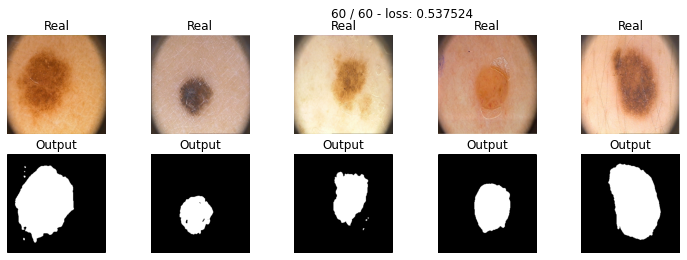

In [48]:
max_epochs = 60
losses = []
tr_losses = []
val_score = []
tr_score = []
optimaizer = optim.AdamW(unet2_model.parameters())
train(unet2_model, optimaizer, bce_loss, max_epochs, data_tr, data_val,losses,tr_losses,val_score,tr_score)

In [50]:
score_model(unet2_model, iou_pytorch, data_val)

0.706000030040741

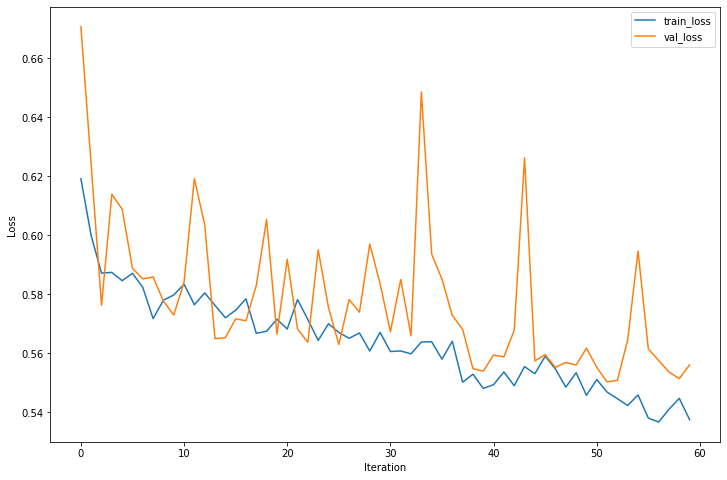

In [51]:
plt.figure(figsize=(12, 8))
plt.plot(tr_losses, label="train_loss")
plt.plot(losses, label="val_loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

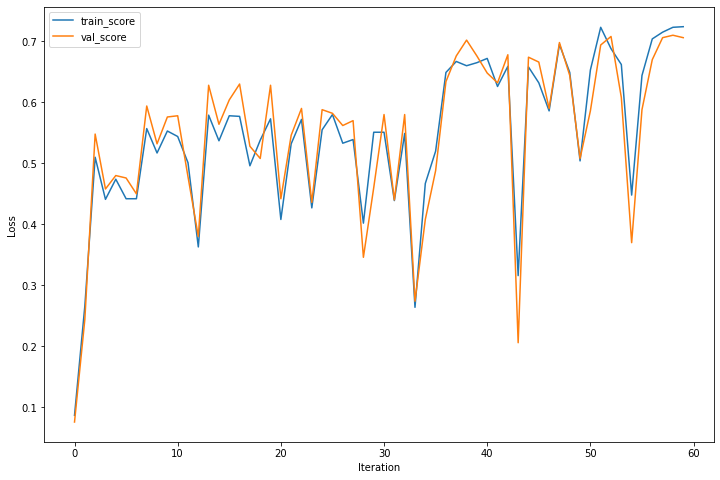

In [52]:
plt.figure(figsize=(12, 8))
plt.plot(tr_score, label="train_score")
plt.plot(val_score, label="val_score")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

Сделайте вывод, какая из моделей лучше

Модель Unet была эффективнее, думаю это связано с тем, что при Upsampling использовались сохраненные индекса пуллинга.

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

**Отчет**

Прошу прощения за плохо оформленный ноутбук и отчет,В связи с тем, что обучение происходит долго и времени до дедлайна осталось совсем немного представляю отчет в сжатом формате.

Модель SegNet продемонстрировала лучший результат с BCE лоссом. Графики представлены по ходу решения задач.

Думаю значение score 0.71 не является лучшим результатом для SegNet, так как на 40 эпохе модель начинает переобучаться, то аугументация данных скорее всего исправила бы положение. Также мною были в 2 раза уменьшены входные/выходные каналы (в связи с тем, что Cuda переполнялась с исходным вариантом ), вероятно ахитектура модели по умолчанию выдала бы лучший результат. 

Модель Unet2 показала результат хуже чем Unet, по моему мнению связано это с тем, что в Unet при апсемпле использовались сохраненные индексы пуллинга, что позволяла ей потерять меньше информации.

Лучшей архитектурой из моих тестов является Unet + BCEloss : 0.72  acceracy без аугументаций